In [11]:
# cargamos las librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from joblib import load
from sklearn.preprocessing import StandardScaler

In [12]:
# creamos función para cargar modelo Adaboost
def load_model():
    model = load('../Modelos/best_adaboost.pkl')
    return model



## **_1. Lectura (carga) de los Datos_**

In [13]:
# importamos archivo de datos sin normalizar para los análisis 
df = pd.read_csv('../Data/df_final_pay_sin_mt.csv', decimal='.')

In [14]:
df.head()

,year_2023,year_2024,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,CAT 798-AC,KOM-CHQ,KOM.960E5,Kom.930E-4,Kom.930E-4SE,Kom.930EN,Kom.930ER,Kom.930ER-MT,Kom.980E5,Komatsu AHS
0,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,395.0,96.0,240.0,0.0,132.0,24.0
1,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,396.0,96.0,240.0,0.0,132.0,24.0
2,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,394.0,96.0,240.0,0.0,132.0,24.0
3,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,95.0,396.0,96.0,240.0,0.0,132.0,24.0
4,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,395.0,96.0,240.0,0.0,132.0,24.0


In [15]:
# generamos columna de validación de payload mean
df['payload_validation'] = np.where(df['payload'] >= df.payload.mean(), 
                                        np.int8(1), np.int8(0))

In [16]:
df.payload_validation.value_counts()

payload_validation
0    825
1    742
Name: count, dtype: int64

In [17]:
# calculamos la disponibilidad de los camiones
df['truck_avail'] = (df.total - (df.mantencion + df.mecanica + df.electrica + df.mant_excl + df.mec_excl + df.elec_excl + df.som_excl)) / df.total

In [18]:
df.truck_avail.describe()

count    1567.000000
mean        0.757987
std         0.039612
min         0.622591
25%         0.733914
50%         0.761742
75%         0.786180
max         0.901208
Name: truck_avail, dtype: float64

## **2. Preparamos el Dataset**

In [19]:
# transformamos las variables bool a categorical y le asignamos 0 o 1
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].apply(lambda x: x.astype('category').cat.codes).astype('category')

In [20]:
# guardamos la media y la desviación estándar de las variables numéricas
df_estadisticas_up = pd.DataFrame()
df_estadisticas_down = pd.DataFrame()

df_numeric = df.select_dtypes(include='float64')
df_estadisticas_up = df_numeric[df.payload_validation == 1].agg(['mean', 'std']).T
df_estadisticas_down = df_numeric[df.payload_validation == 0].agg(['mean', 'std']).T

# cambiamos el nombre de las filas
df_estadisticas_up = df_estadisticas_up.rename(index={0: 'mean', 1: 'std'})
df_estadisticas_down = df_estadisticas_down.rename(index={0: 'mean', 1: 'std'})

# guardamos el archivo con las estadísticas
df_estadisticas_up.to_csv('../Data/df_estadisticas_up.csv')
df_estadisticas_down.to_csv('../Data/df_estadisticas_down.csv')

In [21]:
# estandarizamos las variables numéricas
col_num = df.drop(columns=['payload','truck_avail','payload_validation'], axis=1).select_dtypes(include=['float64','int64']).columns

scaler = StandardScaler()
df[col_num] = scaler.fit_transform(df[col_num])

In [22]:
len(df.columns)

86

In [23]:
# seleccionamos las variables que vamos a usar
df_selected = df[['payload', 'year_2023', 'year_2024', 'month_3', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'day_10', 'day_11', 'day_13', 'day_15', 'day_16',
       'day_17', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25',
       'day_26', 'day_27', 'day_28', 'day_30', 'day_31', 'shift_B', 'crew_E2',
       'crew_E3', 'crew_E4', 'efectivo', 'mantencion', 'mecanica', 'electrica',
       'mant_excl', 'mec_excl', 'demora', 'r_noprg', 'waiting', 'queued',
       'distance_down_level', 'distance_up', 'distance_up_level',
       'expected_time', 'lift_down', 'lift_down_level', 'lift_up',
       'lift_up_level', 'travel_time', 'CAT 797-F', 'CAT 798-AC', 'KOM-CHQ',
       'KOM.960E5', 'Kom.930E-4', 'Kom.930E-4SE', 'Kom.930ER-MT', 'Kom.980E5',
       'Komatsu AHS', 'truck_avail', 'payload_validation']].copy()

In [24]:
len(df_selected.columns)

67

In [25]:
df_selected.shape

(1567, 67)

In [26]:
df_selected.payload.mean()

142357.4639507874

In [27]:
# generamos dataframe de características con payload_validation = 1 (sobre la media)
df_caracteristicas_up = df_selected[df_selected.payload_validation == 1].drop(columns=['payload', 
                                                                                       'payload_validation',
                                                                                       'truck_avail'], axis=1).copy()
df_caracteristicas_up = df_caracteristicas_up.reset_index(drop=True)
df_caracteristicas_up.shape

(742, 64)

In [28]:
# guardamos columnas de comparación up
df_com_up = df_selected[df_selected.payload_validation == 1][['payload','distance_up_level','truck_avail']].copy()
df_com_up = df_com_up.reset_index(drop=True)
df_com_up.shape

(742, 3)

In [29]:
# guardamos el archivo de columnas de comparación up
df_com_up.to_csv('../Data/df_com_up_var1.csv', index=False)

In [30]:
# generamos dataframe de características con payload_validation = 0 (bajo la media)
df_caracteristicas_down = df_selected[df_selected.payload_validation == 0].drop(columns=['payload', 
                                                                                         'payload_validation',
                                                                                         'truck_avail'], axis=1).copy()
df_caracteristicas_down = df_caracteristicas_down.reset_index(drop=True)
df_caracteristicas_down.shape

(825, 64)

In [31]:
# guardamos columnas de comparación down
df_com_down = df_selected[df_selected.payload_validation == 0][['payload','distance_up_level','truck_avail']].copy()
df_com_down = df_com_down.reset_index(drop=True)
df_com_down.shape

(825, 3)

In [32]:
# guardamos el archivo de columnas de comparación down
df_com_down.to_csv('../Data/df_com_down_var1.csv', index=False)

## **3. Análisis Exploratorio de Datos (EDA)**

### **3.1. Distance Up Level**

#### **3.1.1. Análisis de la Variable**

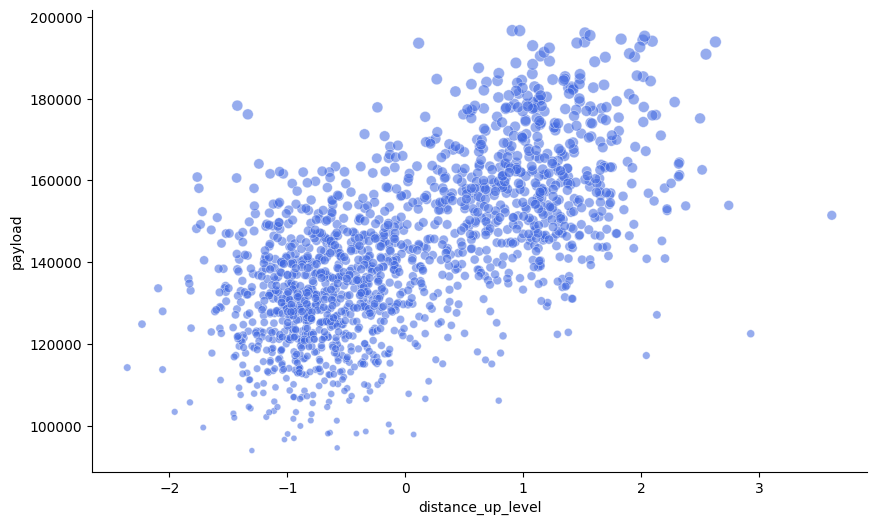

In [33]:
# relación entre distance_up_level y payload
plt.figure(figsize=(10, 6))

# definimos una paleta de colores
custom_palette = {0: 'slategray', 1: 'tomato'}

sns.scatterplot(x='distance_up_level',  
                y='payload',
                data=df, 
                #hue='payload_validation',
                #style='payload_validation',
                size='payload',
                markers=['o', 'h'],
                legend= False,
                alpha=0.55,
                #linewidth=0.3,
                #edgecolor='darkgrey',
                #palette = custom_palette,
                color='royalblue'
                )

# mejoramos la visualización
sns.despine()

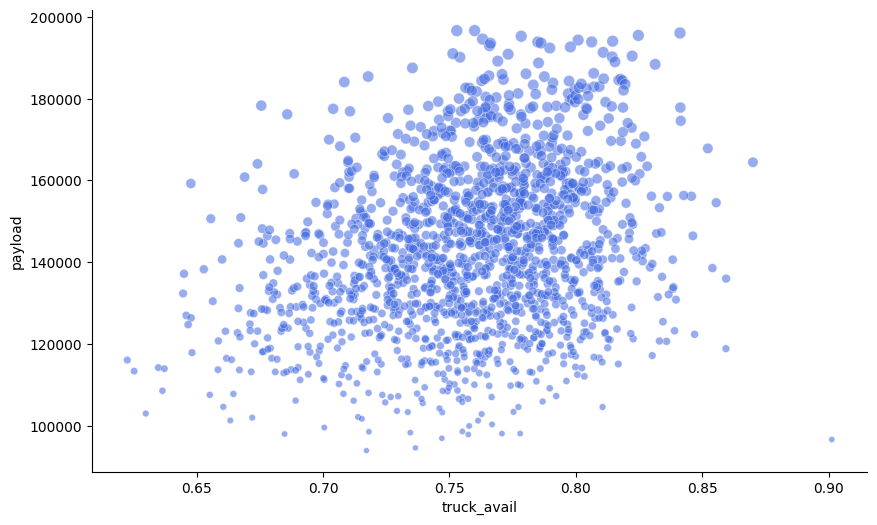

In [34]:
# relación entre distance_up_level y payload
plt.figure(figsize=(10, 6))

# definimos una paleta de colores
custom_palette = {0: 'slategray', 1: 'tomato'}

sns.scatterplot(x='truck_avail',  
                y='payload',
                data=df, 
                #hue='payload_validation',
                #style='payload_validation',
                size='payload',
                markers=['o', 'h'],
                legend= False,
                alpha=0.55,
                #linewidth=0.3,
                #edgecolor='darkgrey',
                #palette = custom_palette,
                color='royalblue'
                )

# mejoramos la visualización
sns.despine()

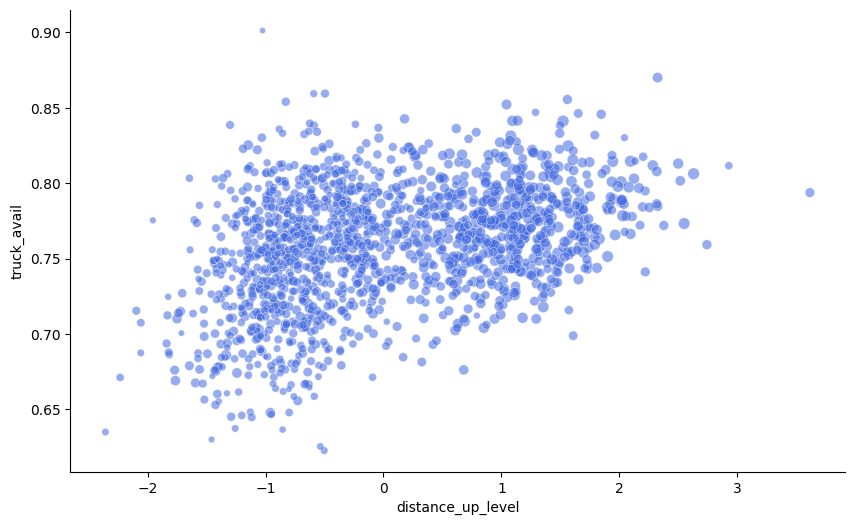

In [35]:
# relación entre distance_up_level y truck_avail
plt.figure(figsize=(10, 6))
# definimos una paleta de colores
custom_palette = {0: 'slategray', 1: 'tomato'}
sns.scatterplot(x='distance_up_level',
                y='truck_avail', 
                data=df, 
                #hue='payload_validation', 
                #style='payload_validation',
                size='payload',
                markers=['o', 's'],
                legend= False,
                alpha=0.55,
                #linewidth=0.3,
                #edgecolor='darkgrey',
                #palette = custom_palette,
                color='royalblue'
                )

# mejoramos la visualización
sns.despine()

In [36]:
import plotly.graph_objects as go
import numpy as np

# Datos de ejemplo
x = df.truck_avail
y = df.distance_up_level
z = df.payload

# Crear gráfico de dispersión 3D
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(size=7, 
                color='royalblue', 
                opacity=0.5, 
                #line=dict(color='blue', width=0.01)
                )
)])

# Personalizar el eje X
fig.update_layout(
    scene=dict(
        xaxis=dict(
            title='truck_avail',  # Título del eje X
            titlefont=dict(size=18, color='rgba(62, 62, 62, 0.8)'),  # Fuente del título
            tickfont=dict(size=14, color='rgba(62, 62, 62, 0.8)'),  # Fuente de las etiquetas
            gridcolor='rgba(62, 62, 62, 0.2)',  # Color de las líneas de la cuadrícula
            zerolinecolor='rgba(62, 62, 62, 0.5)',  # Color de la línea en cero
            showgrid=True,  # Mostrar cuadrícula
            showline=True,  # Mostrar línea del eje
            showticklabels=True,  # Mostrar etiquetas
            linecolor='rgba(62, 62, 62, 0.8)',  # Color de la línea del eje
            ticks='outside',  # Posición de las marcas
            backgroundcolor='rgba(50, 50, 50, 0.5)'  # Fondo más oscuro para ejes
        ),
        yaxis=dict(
            title='distance_up_level',
            titlefont=dict(size=18, color='rgba(62, 62, 62, 0.8)'),
            tickfont=dict(size=14, color='rgba(62, 62, 62, 0.8)'),
            gridcolor='rgba(62, 62, 62, 0.2)',
            zerolinecolor='rgba(62, 62, 62, 0.5)',
            showgrid=True,
            showline=True,
            showticklabels=True,
            linecolor='rgba(62, 62, 62, 0.8)',
            ticks='outside',
            backgroundcolor='rgba(50, 50, 50, 0.5)'
        ),
        zaxis=dict(
            title='payload',
            titlefont=dict(size=18, color='rgba(62, 62, 62, 0.8)'),
            tickfont=dict(size=14, color='rgba(62, 62, 62, 0.8)'),
            gridcolor='rgba(62, 62, 62, 0.2)',
            zerolinecolor='rgba(62, 62, 62, 0.5)',
            showgrid=True,
            showline=True,
            showticklabels=True,
            linecolor='rgba(62, 62, 62, 1)',
            ticks='outside',
            backgroundcolor='rgba(50, 50, 50, 0.5)'
            
            )
    ),
    title='Gráfico de Dispersión 3D Interactivo',
    width=1000,
    height=1000,
    margin=dict(l=0, r=0, b=100, t=50),
    paper_bgcolor='rgba(255, 255, 255, 1)',
    plot_bgcolor='rgba(10, 10, 10, 1)'
)

# Mostrar el gráfico
fig.show()


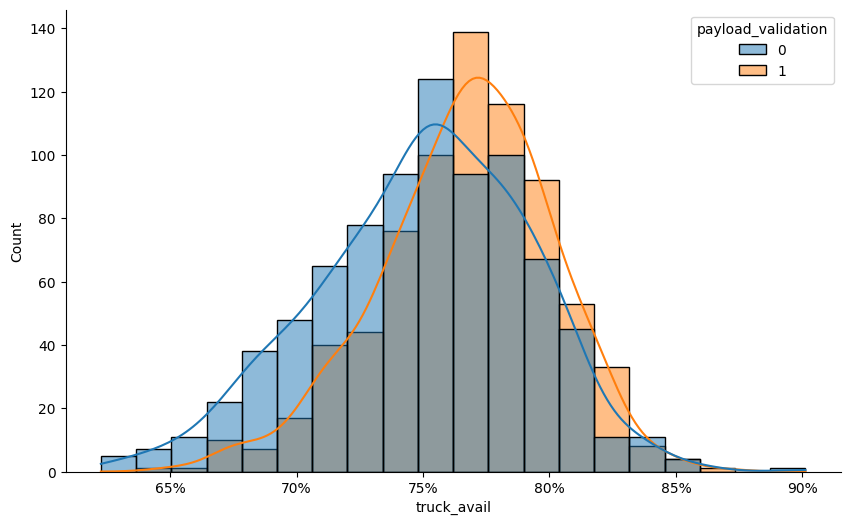

In [37]:
# generamos un grafico de frecuencia de la variable truck_avail
plt.figure(figsize=(10, 6))
sns.histplot(data=df,
             x='truck_avail', 
             bins=20, 
             color='royalblue', 
             kde=True,
             hue='payload_validation')
             
# damos formato de porcentaje al eje x
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

# mejoramos la visualización
sns.despine()
plt.show()

#### **3.1.2. Evaluación de las características con la nueva variable en el modelo**

In [38]:
# generamos vector con las distancias por sobre la media
distance_up = pd.DataFrame(df_selected[df_selected.payload_validation == 1].distance_up_level, 
                           columns=['distance_up_level']) 
distance_up.shape

(742, 1)

In [39]:
# generamos dataframe con características objetivo
df_caract_obj = df_caracteristicas_down.drop(columns=['distance_up_level'], axis=1)
df_caract_obj.shape

(825, 63)

In [40]:
# cargamos el modelo
best_adaboost = load_model()

In [44]:
# Precalculamos la media del payload para evitar recalcularla en cada iteración
payload_mean = df_selected.payload.mean()

# Lista para almacenar los resultados
results = []

features_start_all = df_caract_obj.iloc[:, :48].values
features_end_all = df_caract_obj.iloc[:, 48:].values

for i in range(df_caract_obj.shape[0]):
    features_start = features_start_all[i]
    features_end = features_end_all[i]
    
    # Repetimos las características para coincidir con el tamaño de distance_up
    features_start_repeated = pd.DataFrame([features_start]*distance_up.shape[0], columns=df_caract_obj.columns[:48])
    features_end_repeated = pd.DataFrame([features_end]*distance_up.shape[0], columns=df_caract_obj.columns[48:])
    
    # Combinamos las características con distance_up
    caract_eval = pd.concat([
        features_start_repeated.reset_index(drop=True),
        distance_up.reset_index(drop=True),
        features_end_repeated.reset_index(drop=True)
    ], axis=1)
    
    # Evaluamos el modelo de forma vectorizada
    predictions = best_adaboost.predict(caract_eval)
    
    # Buscamos los índices donde la predicción cumple la condición
    valid_indices = np.where(predictions >= payload_mean)[0]
    
    if len(valid_indices) > 0:
        # Si existen índices válidos, tomamos el primero
        indice_j = valid_indices[0]
        pred_j = predictions[indice_j]
        cumple = 'cumple'
    else:
        # Si no, tomamos el último índice
        indice_j = distance_up.shape[0] - 1
        pred_j = predictions[indice_j]
        cumple = 'no_cumple'
    
    # Construimos el vector de resultado
    vec_resultado = np.concatenate([
        [pred_j],
        features_start,
        distance_up.iloc[indice_j].values,
        features_end,
        [cumple]
    ])
    
    # Agregamos el vector a la lista de resultados
    results.append(vec_resultado)

# Convertimos la lista de resultados en un DataFrame
df_resultado = pd.DataFrame(results, columns=['prediction'] + list(df_caract_obj.columns[:48]) + list(distance_up.columns) + list(df_caract_obj.columns[48:]) + ['status'])


In [45]:
df_resultado.status.value_counts()

status
cumple       512
no_cumple    313
Name: count, dtype: int64

In [46]:
# guardamos el dataframe en un archivo csv
df_resultado.to_csv('../Data/df_resultado_var1(vec).csv', index=False)